In [1]:
import pyedflib # ref: https://pyedflib.readthedocs.io/en/latest/
import pandas as pd
import numpy as np
import os
from datetime import timedelta
import matplotlib.pyplot as plt
from scipy import signal
import yasa
import seaborn as sns
sns.set(font_scale=1.2)
import mne

In [2]:
read_folder = './clips/'
# subjects: 4001(E0, EC), 4032(E0, EP), 4191(E0, EP)
id = 'SC401100'
psg_id = id + 'E0'
hypnogram_id = id + 'EH'

channels = ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal']
channel = channels[1]
signal_path = os.path.join(read_folder, f'{psg_id}-PSG.edf')
label_path = os.path.join(read_folder, f'{hypnogram_id}-Hypnogram.edf')

#### Old pySleepEDF snippets


In [3]:
# read EDF files
if 'edf_label' and 'edf_label' in globals():
    del edf_signal, edf_label

edf_signal = pyedflib.EdfReader(signal_path)
edf_label = pyedflib.EdfReader(label_path)

# read data
annotations = edf_label.readAnnotations()
start = edf_signal.getStartdatetime()
signals, frequencies = edf_signal.getSignalLabels(), edf_signal.getSampleFrequencies()
data = []
for ch_idx, sig_name, freq in zip( range(len(signals)), signals, frequencies,):
    sig = edf_signal.readSignal(chn=ch_idx)
    idx = pd.date_range(  start=start, periods=len(sig), freq=pd.Timedelta(1 / freq, unit="s") )
    data += [pd.Series(sig, index=idx, name=sig_name)]


In [4]:
for ele in zip(signals, frequencies):
    print(ele)

('EEG Fpz-Cz', 100.0)
('EEG Pz-Oz', 100.0)
('EOG horizontal', 100.0)
('Resp oro-nasal', 1.0)
('EMG submental', 1.0)
('Temp rectal', 1.0)
('Event marker', 1.0)


# Try Raw mne

In [5]:
# raw = mne.io.read_raw_edf(signal_path, eog=[2], preload=True)
# # Downsample the data to 100 Hz
# raw.resample(100)
# # Apply a bandpass filter from 0.1 to 40 Hz
# raw.filter(0.1, 40)
# # Select a subset of EEG channels
# channel_names = raw.info['ch_names']
# # 2 eeg, 1 eog, all at 100Hz
# raw.pick(channel_names[:3])

In [6]:
# raw._data

In [7]:
# raw[2]

# COntinue

In [8]:
# create DataFrames
annotations_df = pd.DataFrame(annotations)
annotations_df = annotations_df.T
annotations_df.rename(columns={0: "Onset", 1: "Duration", 2:"Annotations"}, inplace=True)
signal_df =pd.concat(data[:3], axis=1)

In [9]:
signal_df['N1'] = 0

def check_sleep_stage(row):
    start_time = start + timedelta(seconds = int(annotations_df['Onset'].iloc[1]))
    end_time = start + timedelta(seconds = int(annotations_df['Onset'].iloc[1])) + timedelta(seconds = int(annotations_df['Duration'].iloc[1]))
    if start_time <= pd.to_datetime(row.name) < end_time:
        return int(1)
    else:
        return int(0)

signal_df['N1'] = signal_df.apply(check_sleep_stage, axis=1)

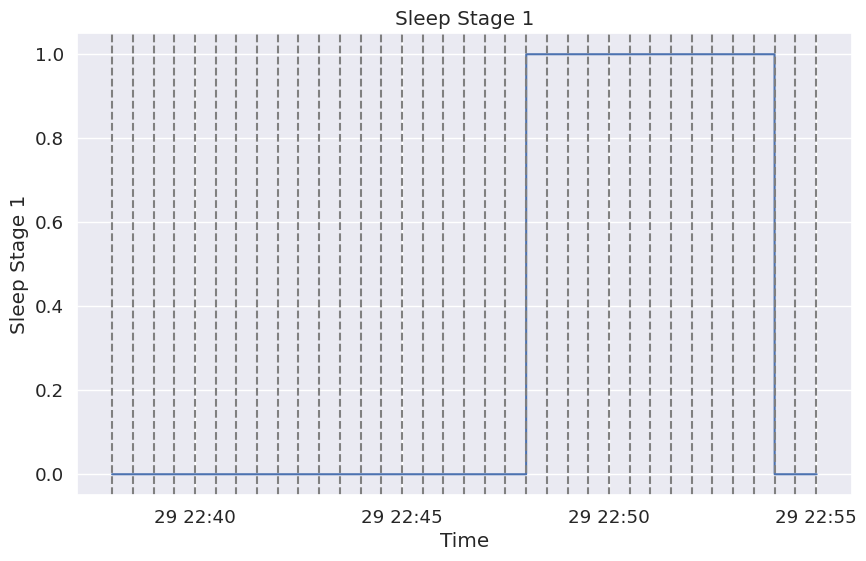

In [10]:
plt.figure(figsize=(10, 6))
# 繪製signal_df['sleep_stage_1']的折線圖
plt.plot(signal_df.index, signal_df['N1'])

# 繪製灰色虛線
time_ticks = pd.date_range(start=signal_df.index.min(), end=signal_df.index.max(), freq='30S')
for time_tick in time_ticks:
    plt.axvline(time_tick, color='gray', linestyle='--')
# 設定圖表標題和標籤
plt.title('Sleep Stage 1')
plt.xlabel('Time')
plt.ylabel('Sleep Stage 1')

# 顯示圖表
plt.show()
# plt.savefig('/fig/' + )

In [11]:
signal_df.shape

(102100, 4)

In [12]:
# rem = yasa.rem_detect(loc, roc, sf, hypno=None, include=4, amplitude=(50, 325), 
#                  duration=(0.3, 1.5), freq_rem=(0.5, 5), remove_outliers=False, 
#                  verbose=False)

# # Get the detection dataframe
# events = rem.summary()
# events.round(3)

In [13]:
signal_df

,EEG Fpz-Cz,EEG Pz-Oz,EOG horizontal,N1
1989-03-29 22:38:00.000,6.725275,8.086691,28.853480,0
1989-03-29 22:38:00.010,8.319414,-8.177045,24.838828,0
1989-03-29 22:38:00.020,14.197802,1.039072,7.776557,0
1989-03-29 22:38:00.030,9.515018,-19.380952,-0.252747,0
1989-03-29 22:38:00.040,8.020513,-19.471306,-5.772894,0
...,...,...,...,...
1989-03-29 22:55:00.950,0.049817,0.045177,0.249084,0
1989-03-29 22:55:00.960,0.049817,0.045177,0.249084,0
1989-03-29 22:55:00.970,0.049817,0.045177,0.249084,0
1989-03-29 22:55:00.980,0.049817,0.045177,0.249084,0


In [14]:
from scipy import signal

sf=100.0
start_time = 1025
interval = 30
start_idx = int(start_time * sf)
end_idx = min(int((start_time + interval) * sf), len(signal_df))
data_range = signal_df.iloc[start_idx:end_idx]

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.dates as mdates
import pandas as pd
def lol(signal_df):
    num_columns = len(signal_df.columns)

    fig, axes = plt.subplots(num_columns, 1, figsize=(20, 12), sharex=True)

    # 迴圈遍歷每個欄位
    for i, column in enumerate(signal_df.columns):
        # 取得目前的軸
        ax = axes[i]

        # 繪製折線圖
        ax.plot(signal_df.index, signal_df[column])
        
        # 繪製虛線
        start_time = signal_df.index[0]
        end_time = signal_df.index[-1]
        interval = pd.Timedelta(seconds=30)
        current_time = start_time + interval
        while current_time < end_time:
            ax.axvline(x=current_time, linestyle='--', color='gray')
            current_time += interval

        # 設定軸的標籤
        ax.set_ylabel(column)
        loc = mdates.MinuteLocator(interval=1)
        ax.xaxis.set_major_locator(loc)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # 設定圖表標題和共用 x 軸標籤
    fig.suptitle('Signal Visualization')
    axes[-1].set_xlabel('Time')

    # 調整子圖之間的間距
    plt.tight_layout()
    # 顯示圖表
    plt.show()


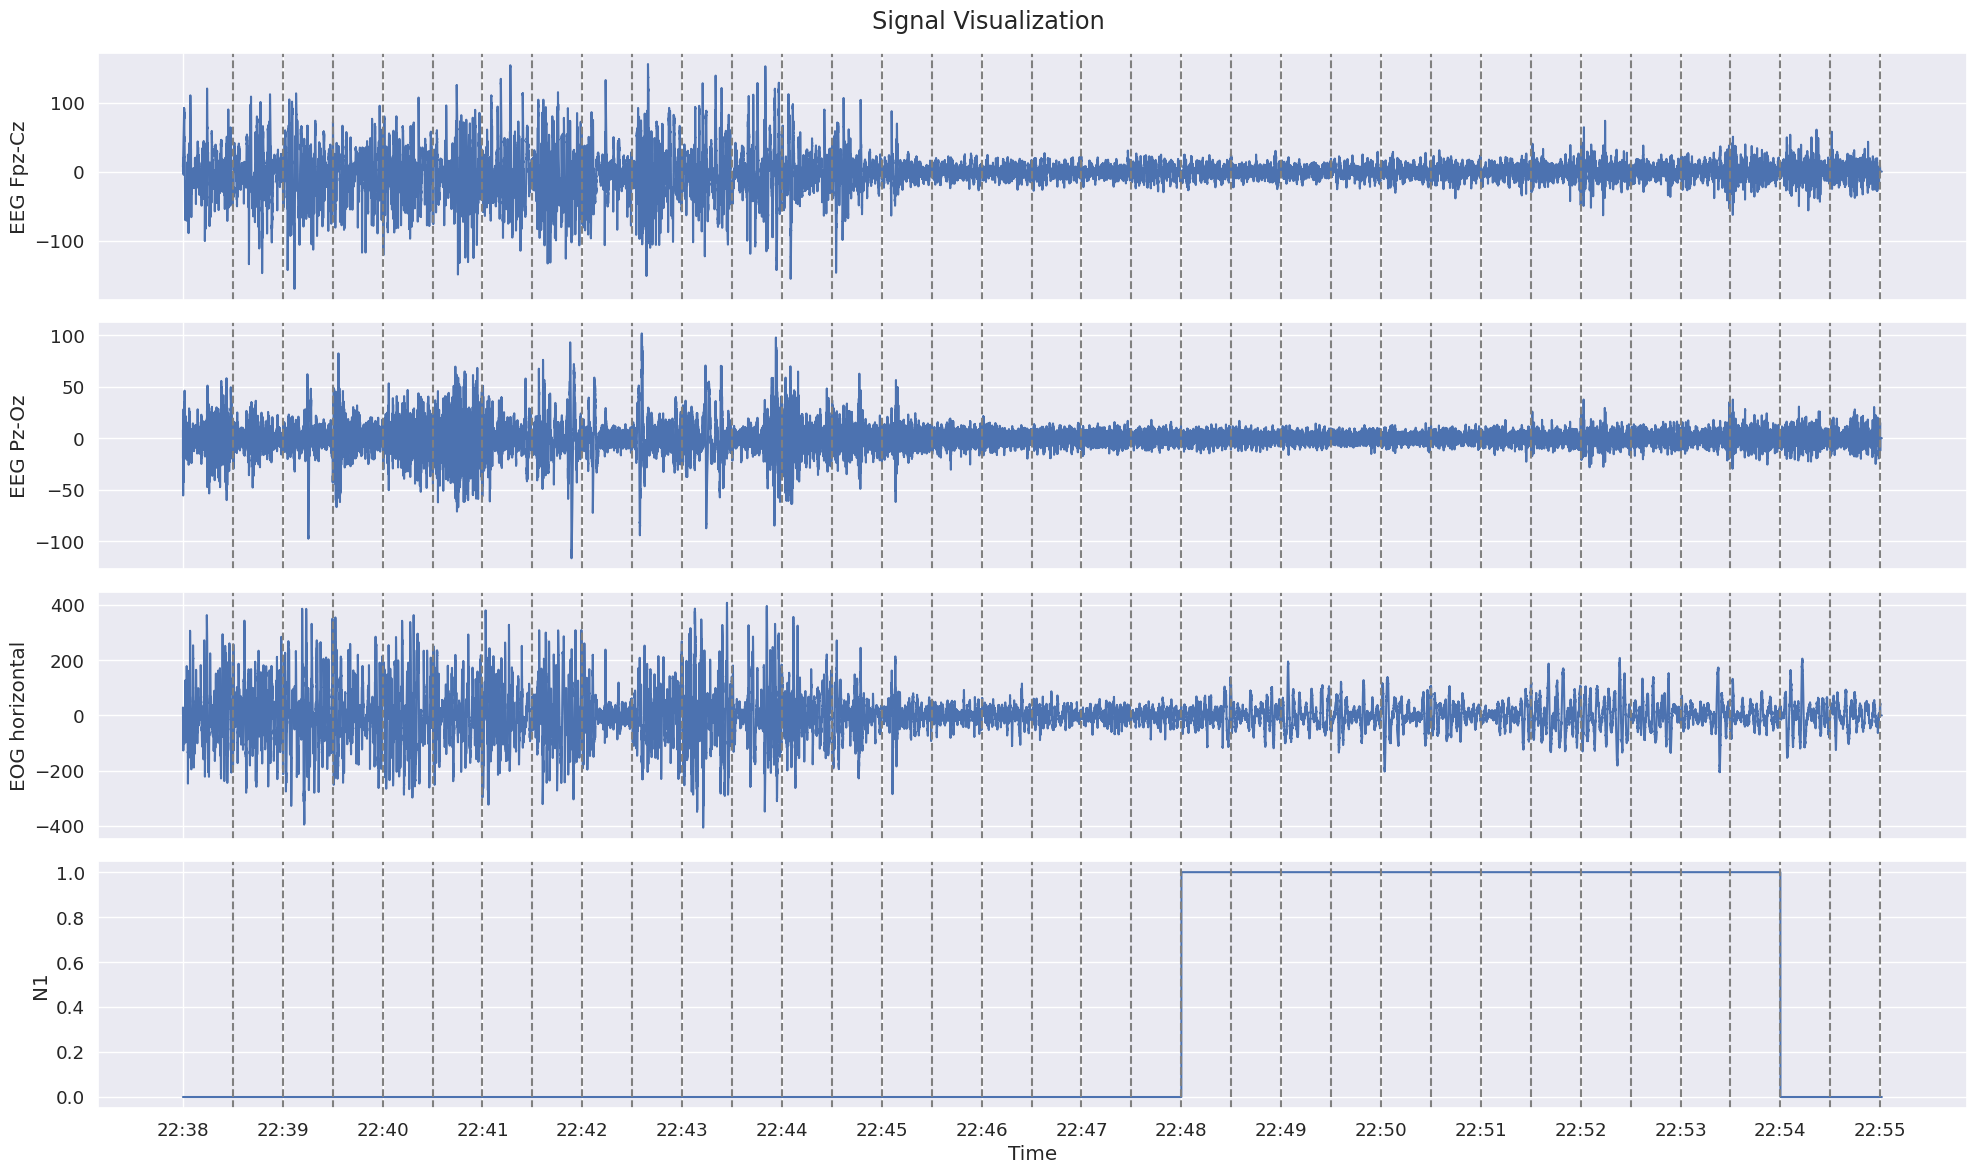

In [16]:
lol(signal_df)

In [48]:
signal_df.iloc[:,0]

1989-03-29 22:38:00.000     6.725275
1989-03-29 22:38:00.010     8.319414
1989-03-29 22:38:00.020    14.197802
1989-03-29 22:38:00.030     9.515018
1989-03-29 22:38:00.040     8.020513
                             ...    
1989-03-29 22:55:00.950     0.049817
1989-03-29 22:55:00.960     0.049817
1989-03-29 22:55:00.970     0.049817
1989-03-29 22:55:00.980     0.049817
1989-03-29 22:55:00.990     0.049817
Freq: 10L, Name: EEG Fpz-Cz, Length: 102100, dtype: float64

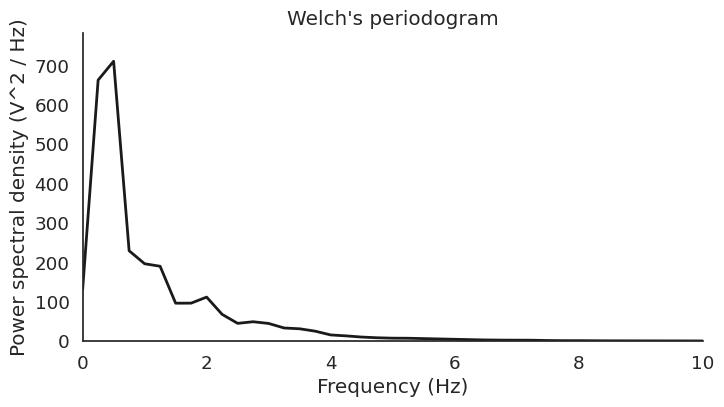

In [17]:



# Define window length (4 seconds)
win = 4 * sf
freqs, psd = signal.welch(signal_df.iloc[:,0], sf, nperseg=win)

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, 10])
sns.despine()

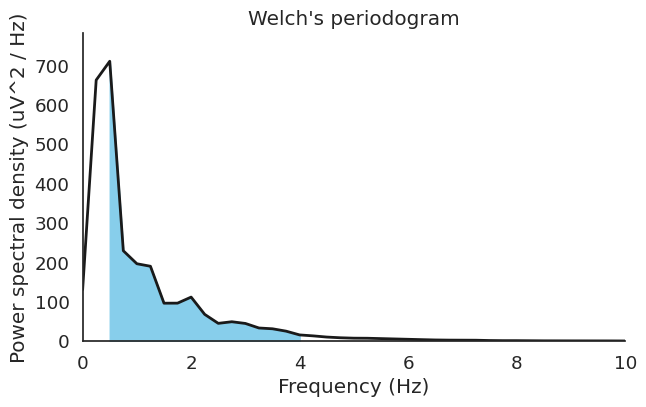

In [18]:
# Define delta lower and upper limits
low, high = 0.5, 4

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 10])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

In [19]:
from scipy.integrate import simps

# Frequency resolution
freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

# Compute the absolute power by approximating the area under the curve
delta_power = simps(psd[idx_delta], dx=freq_res)
print('Absolute delta power: %.3f uV^2' % delta_power)

Absolute delta power: 379.780 uV^2


In [20]:
from scipy.integrate import simps
# Relative delta power (expressed as a percentage of total power)
total_power = simps(psd, dx=freq_res)
delta_rel_power = delta_power / total_power
print('Relative delta power: %.3f' % delta_rel_power)

Relative delta power: 0.542


### Try to slide to find the power relative

In [27]:
len(signal_df)

102100

In [61]:
signal_df.iloc[3000:6000,0]

1989-03-29 22:38:30.000   -22.965568
1989-03-29 22:38:30.010   -16.688645
1989-03-29 22:38:30.020   -19.876923
1989-03-29 22:38:30.030   -21.570696
1989-03-29 22:38:30.040   -28.445421
                             ...    
1989-03-29 22:38:59.950     9.714286
1989-03-29 22:38:59.960     9.315751
1989-03-29 22:38:59.970     6.326740
1989-03-29 22:38:59.980     3.536996
1989-03-29 22:38:59.990    -2.640293
Freq: 10L, Name: EEG Fpz-Cz, Length: 3000, dtype: float64

In [83]:
from scipy import signal

sf=100.0
sec = 30
sliding_interval = int(10 * sf)
interval = int(sf * sec)
delta_plot = []

for start_time in range(0, len(signal_df), sliding_interval):
    start_idx = start_time
    end_idx = min(len(signal_df), start_idx + interval)
    data_range = signal_df.iloc[start_idx:end_idx]

    win = 4 * sf
    freqs, psd = signal.welch(data_range.iloc[:,0], sf, nperseg=win)
    idx_delta = np.logical_and(freqs >= low, freqs <= high)

    # # ===============================
    from scipy.integrate import simps
    # Frequency resolution
    # print(freqs)
    freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25

    # # Compute the absolute power by approximating the area under the curve
    delta_power = simps(psd[idx_delta], dx=freq_res)
    # # print('Absolute delta power: %.3f uV^2' % delta_power)

    # # Relative delta power (expressed as a percentage of total power)
    total_power = simps(psd, dx=freq_res)
    delta_rel_power = delta_power / total_power
    # # print('Relative delta power: %.3f' % delta_rel_power)\
    delta_plot.append({
        'Index': signal_df.index[start_idx],
        'delta_power': delta_power,
        'delta_rel': delta_rel_power
    })
df_delta = pd.DataFrame(delta_plot, index = [x['Index'] for x in delta_plot])
df_delta.drop(columns=['Index'], inplace=True)

/home/jojo/mambaforge/envs/sleep-linear/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 400 is greater than input length  = 100, using nperseg = 100
  warnings.warn('nperseg = {0:d} is greater than input length '


In [84]:
df_delta

,delta_power,delta_rel
1989-03-29 22:38:00,506.061621,0.520751
1989-03-29 22:38:10,411.148544,0.483254
1989-03-29 22:38:20,817.284616,0.560827
1989-03-29 22:38:30,850.158276,0.505316
1989-03-29 22:38:40,1094.318723,0.456161
...,...,...
1989-03-29 22:54:20,111.120574,0.628481
1989-03-29 22:54:30,97.150168,0.659534
1989-03-29 22:54:40,117.024777,0.697634
1989-03-29 22:54:50,92.643627,0.680844


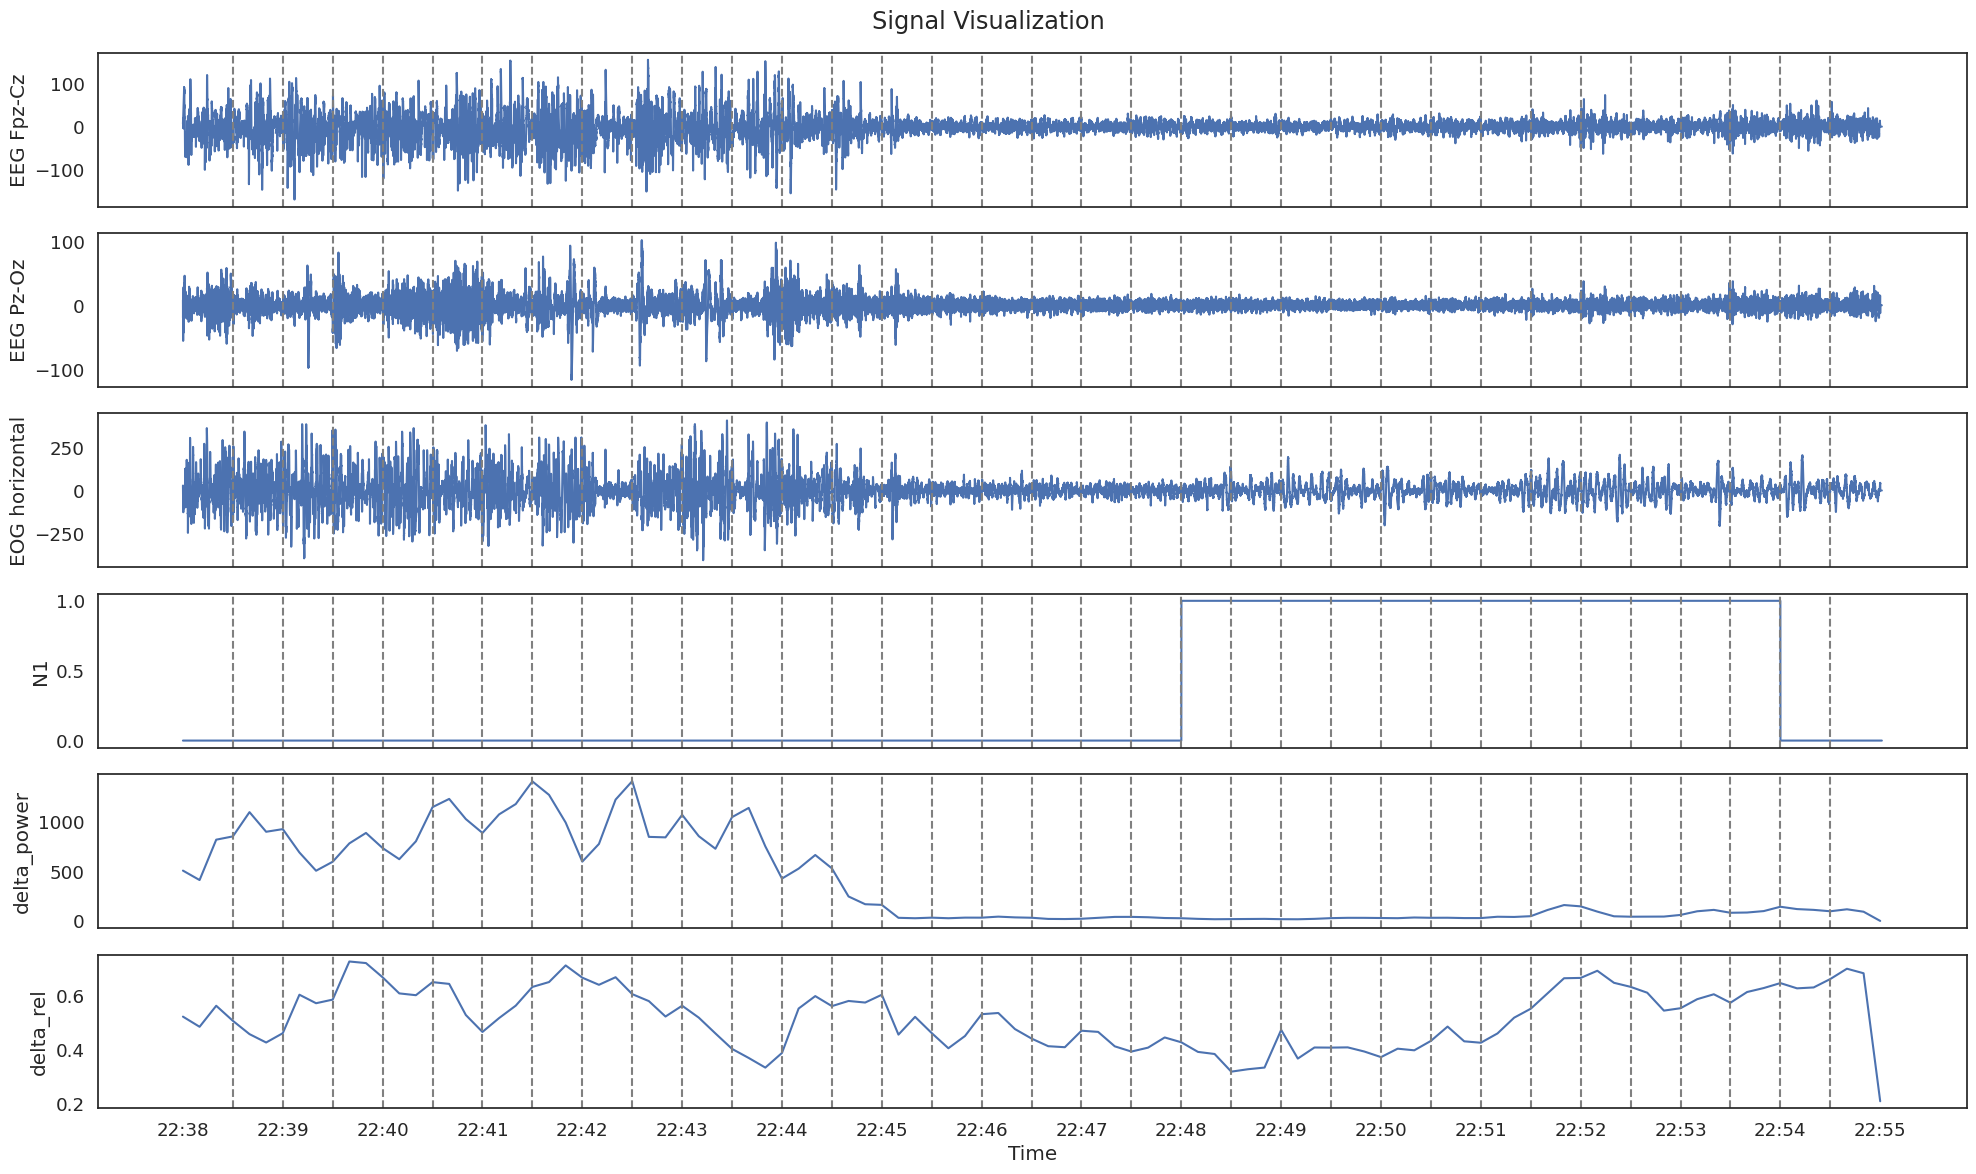

In [96]:
lol(pd.concat([signal_df, df_delta], axis=0))